In [ ]:
#5
import pywt
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s


def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs
#select your attack 

def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return np.uint8(attacked)

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def embedding(image, mark_size, alpha, v='multiplicative'):

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    coeffs3 = pywt.dwt2(LL, 'haar')
    LL2, (LH2, HL2, HH2) = coeffs3

    # Get the locations in LH2
    sign_LH2 = np.sign(LH2)
    abs_LH2 = abs(LH2)
    locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
    rows_LH2 = LH2.shape[0]
    locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates

    # Get the locations in HL2
    sign_HL2 = np.sign(HL2)
    abs_HL2 = abs(HL2)
    locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
    rows_HL2 = HL2.shape[0]
    locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

    # Get the locations in HH2
    sign_HH2 = np.sign(HH2)
    abs_HH2 = abs(HH2)
    locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
    rows_HH2 = HH2.shape[0]
    locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates
    # Embed the watermark in LH2
    watermarked_LH2 = abs_LH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH2[1:], mark)):
        if v == 'additive':
            watermarked_LH2[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_LH2[loc] *= 1 + (alpha * mark_val)
    
     # Embed the watermark in LH
    watermarked_HL2 = abs_HL2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL2[1:], mark)):
        if v == 'additive':
            watermarked_HL2[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HL2[loc] *= 1 + (alpha * mark_val)
    
     # Embed the watermark in HH
    watermarked_HH2 = abs_HH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH2[1:], mark)):
        if v == 'additive':
            watermarked_HH2[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HH2[loc] *= 1 + (alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_LH2 *= sign_LH2
    watermarked_HL2 *= sign_HL2
    watermarked_HH2 *= sign_HH2
    watermarked_LL = pywt.idwt2((LL2, (watermarked_LH2, watermarked_HL2, watermarked_HH2)), 'haar')
    watermarked = pywt.idwt2((watermarked_LL, (LH, HL, HH)), 'haar')

    return mark, watermarked

def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(image, 'haar')
    LL_or, (LH_or, HL_or, HH_or) = coeffs2
    coeffs3 = pywt.dwt2(LL_or, 'haar')
    LL2_or, (LH2_or, HL2_or, HH2_or) = coeffs3

    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs4 = pywt.dwt2(watermarked, 'haar')
    LL_w, (LH_w, HL_w, HH_w) = coeffs4
    coeffs5 = pywt.dwt2(LL_w, 'haar')
    LL2_w, (LH2_w, HL2_w, HH2_w) = coeffs5

    #
    # Get the locations in LH2
    sign_LH2 = np.sign(LH2_or)
    abs_LH2 = abs(LH2_or)
    locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
    rows_LH2 = LH2_or.shape[0]
    locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates

    # Get the locations in HL2
    sign_HL2 = np.sign(HL2_or)
    abs_HL2 = abs(HL2_or)
    locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
    rows_HL2 = HL2_or.shape[0]
    locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

    # Get the locations in HH2
    sign_HH2 = np.sign(HH2_or)
    abs_HH2 = abs(HH2_or)
    locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
    rows_HH2 = HH2_or.shape[0]
    locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1 = np.zeros(mark_size, dtype=np.float64)
    w_ex2 = np.zeros(mark_size, dtype=np.float64)
    w_ex3 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH2[1:mark_size+1]):
        if v=='additive':
            w_ex1[idx] =  (LH2_w[loc] - LH2_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex1[idx] =  (LH2_w[loc] - LH2_or[loc]) / (alpha*LH2_or[loc])
    
     # Embed the watermark
    for idx, loc in enumerate(locations_HL2[1:mark_size+1]):
        if v=='additive':
            w_ex2[idx] =  (HL2_w[loc] - HL2_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex2[idx] =  (HL2_w[loc] - HL2_or[loc]) / (alpha*HL2_or[loc])

     # Embed the watermark
    for idx, loc in enumerate(locations_HH2[1:mark_size+1]):
        if v=='additive':
            w_ex3[idx] =  (HH2_w[loc] - HH2_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex3[idx] =  (HH2_w[loc] - HH2_or[loc]) / (alpha*HH2_or[loc])
    
    w_ex = (w_ex1 + w_ex2 + w_ex3)/3
    return w_ex


plt.figure(figsize=(20, 20))

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alpha = 0.18
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)

mark, watermarked1 = embedding(image, N, alpha, v)
#your attack
attacked = awgn(watermarked1, 20, 123)
plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarked1, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')
#detection

w_ex = detection(image, watermarked1, alpha, N, v)
w_ex_att = detection(image, attacked, alpha, N, v)

#wpsnr
wspnr_watermarked = wpsnr(image, watermarked1)
wpsner_attacked = wpsnr(image, attacked)
print('\n')
print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)
print('WPSNR ATTACKED IMAGE = ', wpsner_attacked)
#similarity
sim_Attacked = similarity(w_ex,w_ex_att)
sim_NOTattacked = similarity(mark,w_ex)
Tau, _ = compute_thr(sim_NOTattacked, N, mark, 1000)
#watermark retrieved?
print('\n')
if sim_NOTattacked > Tau:
        print('Mark has been found in the non-attacked image. SIM = %f' % sim_NOTattacked)
else:
        print('Mark has been lost in the non-attacked image. SIM = %f' % sim_NOTattacked)
if sim_Attacked > Tau:
        print('Mark has been found in the attacked image. SIM = %f' % sim_Attacked)
else:
        print('Mark has been lost in the attacked image. SIM = %f' % sim_Attacked)
print('--------------------------')
print('\n')


In [ ]:
#5
import pywt
import statistics
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt
from math import floor

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s


def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs
#select your attack 

def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return np.uint8(attacked)

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def highResDetector(l, theta):
    if theta == 1:      # in case we are passing HH
        theta = sqrt(2)
    else:               # in all the other cases
        theta = 1
    
    if l == 0:          # in the first  pass of DWT
        l = 1
    else:               # in all the other passes
        l = 0.32
    return theta * l

def lightness (l, i, j, LL3):
    #res = (1/256) * (1 + floor(LL3[i,j] / pow(2, 3 - l)))
    new_i = floor(i / pow(2, 3 - l))
    new_j = floor(j / pow(2, 3 - l))
    
    res = (1/256) * LL3[new_i,new_j]
    if res > 0.5:
        return res
    else:
        return 1 - res

def brigtnessDetector(l, i, j, LL3):
    return 1 + lightness(l, i, j, LL3)

def textureDetector(l, i, j, LL3, dwtMatrix):
    res = 0
    for k in range(0, 4 - l, 1):
        met = 0
        for theta in range (3):
            for x in range(2):
                for y in range(2):
                    new_x = y + ( i // pow(2 ,k))
                    new_y = x + ( j // pow(2 ,k))
                    met += pow(dwtMatrix[k+l][theta][new_x][new_y] , 2) 
        res +=  1 / pow(16, k) * met 
    

    data = []
    for x in range(2):
        for y in range(2):
            new_x = 1 + y + ( i//pow(2,3-l))
            new_y = 1 + x + ( j//pow(2,3-l))
            data.append(LL3[new_x,new_y])
    
    res *= statistics.pvariance(data)
    return res


def quantization(l, theta, i, j, LL3, dwtMatrix):
    return highResDetector(l, theta) * brigtnessDetector(l, i, j, LL3) * textureDetector(l,i,j,LL3,dwtMatrix)

def mask(l, theta, i, j, LL3,dwtMatrix):
    return quantization(l, theta, i, j, LL3,dwtMatrix) / 2

def embedding(image, mark_size, alpha, v='modular'):

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2

    coeffs3 = pywt.dwt2(LL, 'haar')
    LL1, (LH1, HL1, HH1) = coeffs3
    coeffs4 = pywt.dwt2(LL1, 'haar')
    LL2, (LH2, HL2, HH2) = coeffs4

    coeffs5 = pywt.dwt2(LL2, 'haar')
    LL3, (LH3, HL3, HH3) = coeffs5
    dwtMatrix = [[HL,HH,LH,LL],[HL1,HH1,LH1,LL1],[HL2,HH2,LH2,LL2],[HL3,HH3,LH3,LL3]]

    # Get the locations in LH
    sign_LH = np.sign(LH)
    abs_LH = abs(LH)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL = np.sign(HL)
    abs_HL = abs(HL)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH)
    abs_HH = abs(HH)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates
    
    # Embed the watermark in LH
    watermarked_LH = abs_LH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH[1:], mark)):
        if v == 'additive':
            watermarked_LH[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_LH[loc] *= 1 + ( alpha * mark_val)
        elif v == 'modular':
            l = 0
            theta = 0
            x = locations_LH[idx][0]
            y = locations_LH[idx][1]
            watermarked_LH[loc] += (alpha * mask(l, theta, x, y, LL3, dwtMatrix) * mark_val) 
    
     # Embed the watermark in HL
    watermarked_HL = abs_HL.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL[1:], mark)):
        if v == 'additive':
            watermarked_HL[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HL[loc] *= 1 + ( alpha * mark_val)
        elif v == 'modular':
            l = 0
            theta = 2
            x = locations_HL[idx][0]
            y = locations_HL[idx][1]
            watermarked_HL[loc] += (alpha * mask(l, theta, x, y, LL3, dwtMatrix) * mark_val)  
    
     # Embed the watermark in HH
    watermarked_HH = abs_HH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH[1:], mark)):
        if v == 'additive':
            watermarked_HH[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HH[loc] *= 1 + ( alpha * mark_val)
        elif v == 'modular':
            l = 0
            theta = 1
            x = locations_HH[idx][0]
            y = locations_HH[idx][1]
            watermarked_LH[loc] += (alpha * mask(l, theta, x, y, LL3, dwtMatrix) * mark_val)  

    # Restore sign and o back to spatial domain
    watermarked_LH *= sign_LH
    watermarked_HL *= sign_HL
    watermarked_HH *= sign_HH
    watermarked = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')

    return mark, watermarked

def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(image, 'haar')
    LL_or, (LH_or, HL_or, HH_or) = coeffs2
    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(watermarked, 'haar')
    LL_w, (LH_w, HL_w, HH_w) = coeffs2

    #
    # Get the locations in LH
    sign_LH = np.sign(LH_or)
    abs_LH = abs(LH_or)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH_or.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL = np.sign(HL_or)
    abs_HL = abs(HL_or)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL_or.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH_or)
    abs_HH = abs(HH_or)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH_or.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1 = np.zeros(mark_size, dtype=np.float64)
    w_ex2 = np.zeros(mark_size, dtype=np.float64)
    w_ex3 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH[1:mark_size+1]):
        if v=='additive':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) / (alpha*LH_or[loc])
    
     # Embed the watermark
    for idx, loc in enumerate(locations_HL[1:mark_size+1]):
        if v=='additive':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) / (alpha*HL_or[loc])

     # Embed the watermark
    for idx, loc in enumerate(locations_HH[1:mark_size+1]):
        if v=='additive':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) / (alpha*HH_or[loc])
    
    w_ex = (w_ex1 + w_ex2 + w_ex3)/3
    return w_ex


plt.figure(figsize=(20, 20))

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'modular'
alpha = 0.9
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)

mark, watermarked1 = embedding(image, N, alpha, v)


#######  your attack  ########

attacked = awgn(watermarked1, 20, 123)


plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarked1, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')
#detection

w_ex = detection(image, watermarked1, alpha, N, v)
w_ex_att = detection(image, attacked, alpha, N, v)

#wpsnr
wspnr_watermarked = wpsnr(image, watermarked1)
wpsner_attacked = wpsnr(image, attacked)
print('\n')
print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)
print('WPSNR ATTACKED IMAGE = ', wpsner_attacked)
#similarity
sim_Attacked = similarity(w_ex,w_ex_att)
sim_NOTattacked = similarity(mark,w_ex)
Tau, _ = compute_thr(sim_NOTattacked, N, mark, 1000)
#watermark retrieved?
print('\n')
if sim_NOTattacked > Tau:
        print('Mark has been found in the non-attacked image. SIM = %f' % sim_NOTattacked)
else:
        print('Mark has been lost in the non-attacked image. SIM = %f' % sim_NOTattacked)
if sim_Attacked > Tau:
        print('Mark has been found in the attacked image. SIM = %f' % sim_Attacked)
else:
        print('Mark has been lost in the attacked image. SIM = %f' % sim_Attacked)
print('--------------------------')
print('\n')


In [ ]:
def modularAlpha(layer, theta, alpha):
    arrayLayer = [1.0, 0.32, 0.16, 0.1]
    arrayTheta = [1, sqrt(2), 1]

    return alpha * arrayLayer[layer] * arrayTheta[theta]

def embedding(image, mark_size, alpha, v='multiplicative'):

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    coeffs2 = pywt.dwt2(image, 'haar')
    LL0, (LH0, HL0, HH0) = coeffs2

    coeffs3 = pywt.dwt2(LL0, 'haar')
    LL1, (LH1, HL1, HH1) = coeffs3

    coeffs4 = pywt.dwt2(LL1, 'haar')
    LL2, (LH2, HL2, HH2) = coeffs4

    coeffs5 = pywt.dwt2(LL2, 'haar')
    LL3, (LH3, HL3, HH3) = coeffs5

    # Get the locations in LH0
    sign_LH0 = np.sign(LH0)
    abs_LH0 = abs(LH0)
    locations_LH0 = np.argsort(-abs_LH0,axis=None) # - sign is used to get descending order
    rows_LH0 = LH0.shape[0]
    locations_LH0 = [(val//rows_LH0, val%rows_LH0) for val in locations_LH0] # locations as (x,y) coordinates

    # Get the locations in HL0
    sign_HL0 = np.sign(HL0)
    abs_HL0 = abs(HL0)
    locations_HL0 = np.argsort(-abs_HL0,axis=None) # - sign is used to get descending order
    rows_HL0 = HL0.shape[0]
    locations_HL0 = [(val//rows_HL0, val%rows_HL0) for val in locations_HL0] # locations as (x,y) coordinates

    # Get the locations in HH0
    sign_HH0 = np.sign(HH0)
    abs_HH0 = abs(HH0)
    locations_HH0 = np.argsort(-abs_HH0,axis=None) # - sign is used to get descending order
    rows_HH0 = HH0.shape[0]
    locations_HH0 = [(val//rows_HH0, val%rows_HH0) for val in locations_HH0] # locations as (x,y) coordinates
    
    # Embed the watermark in LH0
    watermarked_LH0 = abs_LH0.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH0[1:], mark)):
        if v == 'additive':
            layer = 0
            theta = 0
            watermarked_LH0[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 0
            theta = 0
            watermarked_LH0[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in LH0
    watermarked_HL0 = abs_HL0.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL0[1:], mark)):
        if v == 'additive':
            layer = 0
            theta = 2
            watermarked_HL0[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 0
            theta = 2
            watermarked_HL0[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in HH0
    watermarked_HH0 = abs_HH0.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH0[1:], mark)):
        if v == 'additive':
            layer = 0
            theta = 1
            watermarked_HH0[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 0
            theta = 1
            watermarked_HH0[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)

    # Get the locations in LH1
    sign_LH1 = np.sign(LH1)
    abs_LH1 = abs(LH1)
    locations_LH1 = np.argsort(-abs_LH1,axis=None) # - sign is used to get descending order
    rows_LH1 = LH1.shape[0]
    locations_LH1 = [(val//rows_LH1, val%rows_LH1) for val in locations_LH1] # locations as (x,y) coordinates

    # Get the locations in HL1
    sign_HL1 = np.sign(HL1)
    abs_HL1 = abs(HL1)
    locations_HL1 = np.argsort(-abs_HL1,axis=None) # - sign is used to get descending order
    rows_HL1 = HL1.shape[0]
    locations_HL1 = [(val//rows_HL1, val%rows_HL1) for val in locations_HL1] # locations as (x,y) coordinates

    # Get the locations in HH1
    sign_HH1 = np.sign(HH1)
    abs_HH1 = abs(HH1)
    locations_HH1 = np.argsort(-abs_HH1,axis=None) # - sign is used to get descending order
    rows_HH1 = HH1.shape[0]
    locations_HH1 = [(val//rows_HH1, val%rows_HH1) for val in locations_HH1] # locations as (x,y) coordinates
    
    # Embed the watermark in LH1
    watermarked_LH1 = abs_LH1.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH1[1:], mark)):
        if v == 'additive':
            layer = 1
            theta = 0
            watermarked_LH1[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 1
            theta = 0
            watermarked_LH1[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in LH1
    watermarked_HL1 = abs_HL1.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL1[1:], mark)):
        if v == 'additive':
            layer = 1
            theta = 2
            watermarked_HL1[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 1
            theta = 2
            watermarked_HL1[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in HH1
    watermarked_HH1 = abs_HH1.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH1[1:], mark)):
        if v == 'additive':
            layer = 1
            theta = 1
            watermarked_HH1[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 1
            theta = 1
            watermarked_HH1[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)

# Get the locations in LH2
    sign_LH2 = np.sign(LH2)
    abs_LH2 = abs(LH2)
    locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
    rows_LH2 = LH2.shape[0]
    locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates

    # Get the locations in HL2
    sign_HL2 = np.sign(HL2)
    abs_HL2 = abs(HL2)
    locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
    rows_HL2 = HL2.shape[0]
    locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

    # Get the locations in HH2
    sign_HH2 = np.sign(HH2)
    abs_HH2 = abs(HH2)
    locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
    rows_HH2 = HH2.shape[0]
    locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates

    # Embed the watermark in LH2
    watermarked_LH2 = abs_LH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH2[1:], mark)):
        if v == 'additive':
            layer = 2
            theta = 0
            watermarked_LH2[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 2
            theta = 0
            watermarked_LH2[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in LH2
    watermarked_HL2 = abs_HL2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL2[1:], mark)):
        if v == 'additive':
            layer = 2
            theta = 2
            watermarked_HL2[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 2
            theta = 2
            watermarked_HL2[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in HH2
    watermarked_HH2 = abs_HH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH2[1:], mark)):
        if v == 'additive':
            layer = 2
            theta = 1
            watermarked_HH2[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 2
            theta = 1
            watermarked_HH2[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)

    # Get the locations in LH3
    sign_LH3 = np.sign(LH3)
    abs_LH3 = abs(LH3)
    locations_LH3 = np.argsort(-abs_LH3,axis=None) # - sign is used to get descending order
    rows_LH3 = LH3.shape[0]
    locations_LH3 = [(val//rows_LH3, val%rows_LH3) for val in locations_LH3] # locations as (x,y) coordinates

    # Get the locations in HL3
    sign_HL3 = np.sign(HL3)
    abs_HL3 = abs(HL3)
    locations_HL3 = np.argsort(-abs_HL3,axis=None) # - sign is used to get descending order
    rows_HL3 = HL3.shape[0]
    locations_HL3 = [(val//rows_HL3, val%rows_HL3) for val in locations_HL3] # locations as (x,y) coordinates

    # Get the locations in HH3
    sign_HH3 = np.sign(HH3)
    abs_HH3 = abs(HH3)
    locations_HH3 = np.argsort(-abs_HH3,axis=None) # - sign is used to get descending order
    rows_HH3 = HH3.shape[0]
    locations_HH3 = [(val//rows_HH3, val%rows_HH3) for val in locations_HH3] # locations as (x,y) coordinates

    # Embed the watermark in LH3
    watermarked_LH3 = abs_LH3.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH3[1:], mark)):
        if v == 'additive':
            layer = 3
            theta = 0
            watermarked_LH3[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 3
            theta = 0
            watermarked_LH3[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in LH3
    watermarked_HL3 = abs_HL3.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL3[1:], mark)):
        if v == 'additive':
            layer = 3
            theta = 2
            watermarked_HL3[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 3
            theta = 2
            watermarked_HL3[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in HH3
    watermarked_HH3 = abs_HH3.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH3[1:], mark)):
        if v == 'additive':
            layer = 3
            theta = 1
            watermarked_HH3[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 3
            theta = 1
            watermarked_HH3[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
    # Restore sign and o back to spatial domain
    watermarked_LH3 *= sign_LH3
    watermarked_HL3 *= sign_HL3
    watermarked_HH3 *= sign_HH3
    watermarked_LL2 = pywt.idwt2((LL3, (watermarked_LH3, watermarked_HL3, watermarked_HH3)), 'haar')

    watermarked_LH2 *= sign_LH2
    watermarked_HL2 *= sign_HL2
    watermarked_HH2 *= sign_HH2
    watermarked_LL1 = pywt.idwt2((watermarked_LL2, (watermarked_LH2, watermarked_HL2, watermarked_HH2)), 'haar')

    watermarked_LH1 *= sign_LH1
    watermarked_HL1 *= sign_HL1
    watermarked_HH1 *= sign_HH1
    watermarked_LL0 = pywt.idwt2((watermarked_LL1, (watermarked_LH1, watermarked_HL1, watermarked_HH1)), 'haar')

    watermarked_LH0 *= sign_LH0
    watermarked_HL0 *= sign_HL0
    watermarked_HH0 *= sign_HH0
    watermarked = pywt.idwt2((watermarked_LL0, (watermarked_LH0, watermarked_HL0, watermarked_HH0)), 'haar')

    return mark, watermarked

img_path='lena_grey.bmp'
N = 1024
alpha = 0.8
v = 'multiplicative'

mark, watermarkedPicture = embedding(image, N, alpha, v='multiplicative')
wspnr_watermarked = wpsnr(image, watermarkedPicture)

plt.subplot(121)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title('Watermarked')
plt.imshow(watermarkedPicture, cmap='gray')

print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)


WPSNR non-ATTACKED IMAGE =  58.33639466477248


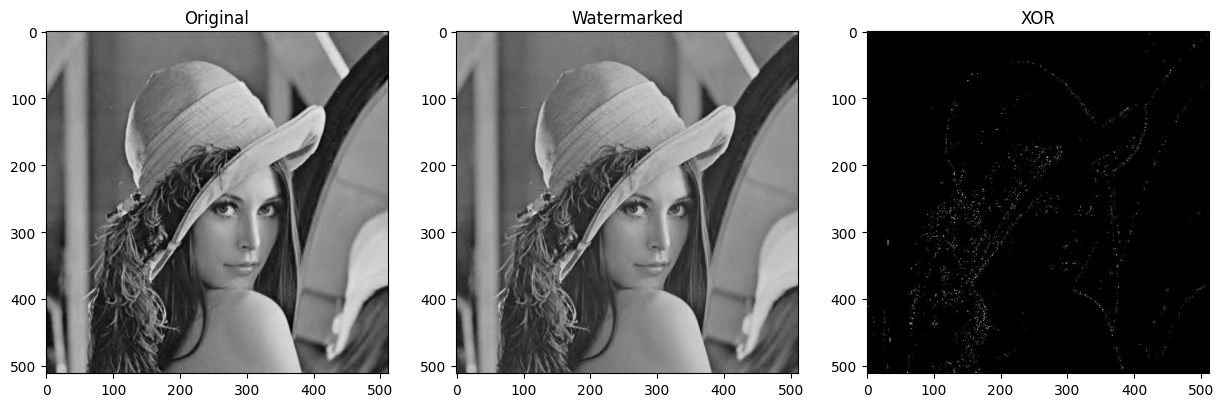

In [28]:
import pywt
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def create_perceptual_mask(subband):

    mask = np.ones(subband.shape)
    mask = compute_brightness_sensitivity(subband) * compute_edge_sensitivity(subband) * compute_texture_sensitivity(subband)
    
    return mask

def compute_brightness_sensitivity(subband):

    # Normalize brightness between 0 and 1
    min_brightness = np.min(subband)
    max_brightness = np.max(subband)
    brightness_sensitivity = (subband - min_brightness) / (max_brightness - min_brightness + 1e-6)
    
    # Invert to give higher sensitivity in dark areas (lower brightness = higher mask value)
    return 1 - brightness_sensitivity

def compute_edge_sensitivity(subband):

    # Compute image gradient (strong edges correspond to higher gradients)
    sobel_x = cv2.Sobel(subband, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(subband, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Normalize gradient magnitude between 0 and 1
    gradient_sensitivity = (gradient_magnitude - np.min(gradient_magnitude)) / (np.max(gradient_magnitude) - np.min(gradient_magnitude) + 1e-6)
    
    return gradient_sensitivity

def compute_texture_sensitivity(subband):
    
    # Compute local variance as a measure of texture
    mean = cv2.blur(subband, (3, 3))
    local_variance = cv2.blur((subband - mean) ** 2, (3, 3))
    
    # Normalize local variance between 0 and 1
    texture_sensitivity = (local_variance - np.min(local_variance)) / (np.max(local_variance) - np.min(local_variance) + 1e-6)
    
    return texture_sensitivity

def modularAlpha(layer, theta, alpha):
    arrayLayer = [1.0, 0.32, 0.16, 0.1]
    arrayTheta = [1, sqrt(2), 1]

    return alpha * arrayLayer[layer] * arrayTheta[theta]

def embedding(image, mark_size, alpha, v='multiplicative'):

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    coeffs2 = pywt.dwt2(image, 'haar')
    LL0, (LH0, HL0, HH0) = coeffs2

    coeffs3 = pywt.dwt2(LL0, 'haar')
    LL1, (LH1, HL1, HH1) = coeffs3

    coeffs4 = pywt.dwt2(LL1, 'haar')
    LL2, (LH2, HL2, HH2) = coeffs4

    coeffs5 = pywt.dwt2(LL2, 'haar')
    LL3, (LH3, HL3, HH3) = coeffs5

    # Create the mask for all the different subbands

    mask_LH0 = np.ones(LH0.shape)
    mask_HL0 = np.ones(HL0.shape)
    mask_HH0 = np.ones(HH0.shape)

    mask_LH1 = np.ones(LH1.shape)
    mask_HL1 = np.ones(HL1.shape)
    mask_HH1 = np.ones(HH1.shape)

    mask_LH2 = np.ones(LH2.shape)
    mask_HL2 = np.ones(HL2.shape)
    mask_HH2 = np.ones(HH2.shape)

    mask_LH0 += create_perceptual_mask(LH0)
    mask_HL0 += create_perceptual_mask(HL0)
    mask_HH0 += create_perceptual_mask(HH0)

    mask_LH1 += create_perceptual_mask(LH1)
    mask_HL1 += create_perceptual_mask(HL1)
    mask_HH1 += create_perceptual_mask(HH1)

    mask_LH2 += create_perceptual_mask(LH2)
    mask_HL2 += create_perceptual_mask(HL2)
    mask_HH2 += create_perceptual_mask(HH2)

    # Get the locations in LH0
    sign_LH0 = np.sign(LH0)
    abs_LH0 = abs(LH0)
    locations_LH0 = np.argsort(-abs_LH0,axis=None) # - sign is used to get descending order
    rows_LH0 = LH0.shape[0]
    locations_LH0 = [(val//rows_LH0, val%rows_LH0) for val in locations_LH0] # locations as (x,y) coordinates

    # Get the locations in HL0
    sign_HL0 = np.sign(HL0)
    abs_HL0 = abs(HL0)
    locations_HL0 = np.argsort(-abs_HL0,axis=None) # - sign is used to get descending order
    rows_HL0 = HL0.shape[0]
    locations_HL0 = [(val//rows_HL0, val%rows_HL0) for val in locations_HL0] # locations as (x,y) coordinates

    # Get the locations in HH0
    sign_HH0 = np.sign(HH0)
    abs_HH0 = abs(HH0)
    locations_HH0 = np.argsort(-abs_HH0,axis=None) # - sign is used to get descending order
    rows_HH0 = HH0.shape[0]
    locations_HH0 = [(val//rows_HH0, val%rows_HH0) for val in locations_HH0] # locations as (x,y) coordinates
    
    # Embed the watermark in LH0
    watermarked_LH0 = abs_LH0.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH0[1:], mark)):
        if v == 'additive':
            layer = 0
            theta = 0
            x = locations_LH0[idx][0]
            y = locations_LH0[idx][1]
            watermarked_LH0[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_LH0[x][y])
        elif v == 'multiplicative':
            layer = 0
            theta = 0
            x = locations_LH0[idx][0]
            y = locations_LH0[idx][1]
            watermarked_LH0[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_LH0[x][y])
    
     # Embed the watermark in HL0
    watermarked_HL0 = abs_HL0.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL0[1:], mark)):
        if v == 'additive':
            layer = 0
            theta = 2
            x = locations_HL0[idx][0]
            y = locations_HL0[idx][1]
            watermarked_HL0[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_HL0[x][y])
        elif v == 'multiplicative':
            layer = 0
            theta = 2
            x = locations_HL0[idx][0]
            y = locations_HL0[idx][1]
            watermarked_HL0[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_HL0[x][y])
    
     # Embed the watermark in HH0
    watermarked_HH0 = abs_HH0.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH0[1:], mark)):
        if v == 'additive':
            layer = 0
            theta = 1
            x = locations_HH0[idx][0]
            y = locations_HH0[idx][1]
            watermarked_HH0[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_HH0[x][y])
        elif v == 'multiplicative':
            layer = 0
            theta = 1
            x = locations_HH0[idx][0]
            y = locations_HH0[idx][1]
            watermarked_HH0[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_HH0[x][y])

    # Get the locations in LH1
    sign_LH1 = np.sign(LH1)
    abs_LH1 = abs(LH1)
    locations_LH1 = np.argsort(-abs_LH1,axis=None) # - sign is used to get descending order
    rows_LH1 = LH1.shape[0]
    locations_LH1 = [(val//rows_LH1, val%rows_LH1) for val in locations_LH1] # locations as (x,y) coordinates

    # Get the locations in HL1
    sign_HL1 = np.sign(HL1)
    abs_HL1 = abs(HL1)
    locations_HL1 = np.argsort(-abs_HL1,axis=None) # - sign is used to get descending order
    rows_HL1 = HL1.shape[0]
    locations_HL1 = [(val//rows_HL1, val%rows_HL1) for val in locations_HL1] # locations as (x,y) coordinates

    # Get the locations in HH1
    sign_HH1 = np.sign(HH1)
    abs_HH1 = abs(HH1)
    locations_HH1 = np.argsort(-abs_HH1,axis=None) # - sign is used to get descending order
    rows_HH1 = HH1.shape[0]
    locations_HH1 = [(val//rows_HH1, val%rows_HH1) for val in locations_HH1] # locations as (x,y) coordinates
    
    # Embed the watermark in LH1
    watermarked_LH1 = abs_LH1.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH1[1:], mark)):
        if v == 'additive':
            layer = 1
            theta = 0
            x = locations_LH1[idx][0]
            y = locations_LH1[idx][1]
            watermarked_LH1[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_LH1[x][y])
        elif v == 'multiplicative':
            layer = 1
            theta = 0
            x = locations_LH1[idx][0]
            y = locations_LH1[idx][1]
            watermarked_LH1[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_LH1[x][y])
    
     # Embed the watermark in HL1
    watermarked_HL1 = abs_HL1.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL1[1:], mark)):
        if v == 'additive':
            layer = 1
            theta = 2
            x = locations_HL1[idx][0]
            y = locations_HL1[idx][1]
            watermarked_HL1[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_HL1[x][y])
        elif v == 'multiplicative':
            layer = 1
            theta = 2
            x = locations_HL1[idx][0]
            y = locations_HL1[idx][1]
            watermarked_HL1[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_HL1[x][y])
    
     # Embed the watermark in HH1
    watermarked_HH1 = abs_HH1.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH1[1:], mark)):
        if v == 'additive':
            layer = 1
            theta = 1
            x = locations_HH1[idx][0]
            y = locations_HH1[idx][1]
            watermarked_HH1[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_HH1[x][y])
        elif v == 'multiplicative':
            layer = 1
            theta = 1
            x = locations_HH1[idx][0]
            y = locations_HH1[idx][1]
            watermarked_HH1[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_HH1[x][y])

# # Get the locations in LH2
#     sign_LH2 = np.sign(LH2)
#     abs_LH2 = abs(LH2)
#     locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
#     rows_LH2 = LH2.shape[0]
#     locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates

#     # Get the locations in HL2
#     sign_HL2 = np.sign(HL2)
#     abs_HL2 = abs(HL2)
#     locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
#     rows_HL2 = HL2.shape[0]
#     locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

#     # Get the locations in HH2
#     sign_HH2 = np.sign(HH2)
#     abs_HH2 = abs(HH2)
#     locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
#     rows_HH2 = HH2.shape[0]
#     locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates

#     # Embed the watermark in LH2
#     watermarked_LH2 = abs_LH2.copy()
#     for idx, (loc,mark_val) in enumerate(zip(locations_LH2[1:], mark)):
#         if v == 'additive':
#             layer = 2
#             theta = 0
#             x = locations_LH2[idx][0]
#             y = locations_LH2[idx][1]
#             watermarked_LH2[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_LH2[x][y])
#         elif v == 'multiplicative':
#             layer = 2
#             theta = 0
#             x = locations_LH2[idx][0]
#             y = locations_LH2[idx][1]
#             watermarked_LH2[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_LH2[x][y])
    
#      # Embed the watermark in HL2
#     watermarked_HL2 = abs_HL2.copy()
#     for idx, (loc,mark_val) in enumerate(zip(locations_HL2[1:], mark)):
#         if v == 'additive':
#             layer = 2
#             theta = 2
#             x = locations_HL2[idx][0]
#             y = locations_HL2[idx][1]
#             watermarked_HL2[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_HL2[x][y])
#         elif v == 'multiplicative':
#             layer = 2
#             theta = 2
#             x = locations_HL2[idx][0]
#             y = locations_HL2[idx][1]
#             watermarked_HL2[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_HL2[x][y])
    
#      # Embed the watermark in HH2
#     watermarked_HH2 = abs_HH2.copy()
#     for idx, (loc,mark_val) in enumerate(zip(locations_HH2[1:], mark)):
#         if v == 'additive':
#             layer = 2
#             theta = 1
#             x = locations_HH2[idx][0]
#             y = locations_HH2[idx][1]
#             watermarked_HH2[loc] += (modularAlpha(layer, theta, alpha) * mark_val * mask_HH2[x][y])
#         elif v == 'multiplicative':
#             layer = 2
#             theta = 1
#             x = locations_HH2[idx][0]
#             y = locations_HH2[idx][1]
#             watermarked_HH2[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val * mask_HH2[x][y])

    # Restore sign and o back to spatial domain

    watermarked_LL2 = pywt.idwt2((LL3, (LH3, HL3, HH3)), 'haar')

    # watermarked_LH2 *= sign_LH2
    # watermarked_HL2 *= sign_HL2
    # watermarked_HH2 *= sign_HH2
    # watermarked_LL1 = pywt.idwt2((watermarked_LL2, (watermarked_LH2, watermarked_HL2, watermarked_HH2)), 'haar')

    watermarked_LL1 = pywt.idwt2((watermarked_LL2, (LH2, HL2, HH2)), 'haar')

    watermarked_LH1 *= sign_LH1
    watermarked_HL1 *= sign_HL1
    watermarked_HH1 *= sign_HH1
    watermarked_LL0 = pywt.idwt2((watermarked_LL1, (watermarked_LH1, watermarked_HL1, watermarked_HH1)), 'haar')

    watermarked_LH0 *= sign_LH0
    watermarked_HL0 *= sign_HL0
    watermarked_HH0 *= sign_HH0
    watermarked = pywt.idwt2((watermarked_LL0, (watermarked_LH0, watermarked_HL0, watermarked_HH0)), 'haar')

    return mark, watermarked

img_path='lena_grey.bmp'
image = cv2.imread(img_path, 0)
N = 1024
alpha = 0.4
v = 'multiplicative'

mark, watermarkedPicture = embedding(image, N, alpha, v='multiplicative')
wspnr_watermarked = wpsnr(image, watermarkedPicture)

cv2.imwrite('./out/watermarkedPicture.bmp', watermarkedPicture)

# Load the images
image1 = cv2.imread('lena_grey.bmp')
image2 = cv2.imread('./out/watermarkedPicture.bmp')

# Convert images to the same data type (uint8)
image1 = image1.astype(np.uint8)
image2 = image2.astype(np.uint8)

# Perform the XOR operation
xor_image = cv2.bitwise_xor(image1, image2)

# Save or display the result
cv2.imwrite('./out/xor_output_image.bmp', xor_image)

plt.figure(figsize=(15, 9))
plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarkedPicture, cmap='gray')
plt.subplot(133)
plt.title('XOR')
plt.imshow(xor_image, cmap='gray')

print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)



WPSNR non-ATTACKED IMAGE =  58.33639466477248
WPSNR ATTACKED IMAGE =  47.51562040492709
[0 1 1 ... 0 1 0]
[ 3.20018845e-16  1.00000000e+00  1.00000000e+00 ... -1.41984522e-15
  1.00000000e+00  0.00000000e+00]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
Threshold:  0.7045969013191931


Mark has been found in the non-attacked image. SIM = 1.000000
Mark has been lost in the attacked image. SIM = 0.674775
--------------------------




/tmp/ipykernel_4464/3127294557.py:5: RuntimeWarning: invalid value encountered in scalar divide
  s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))


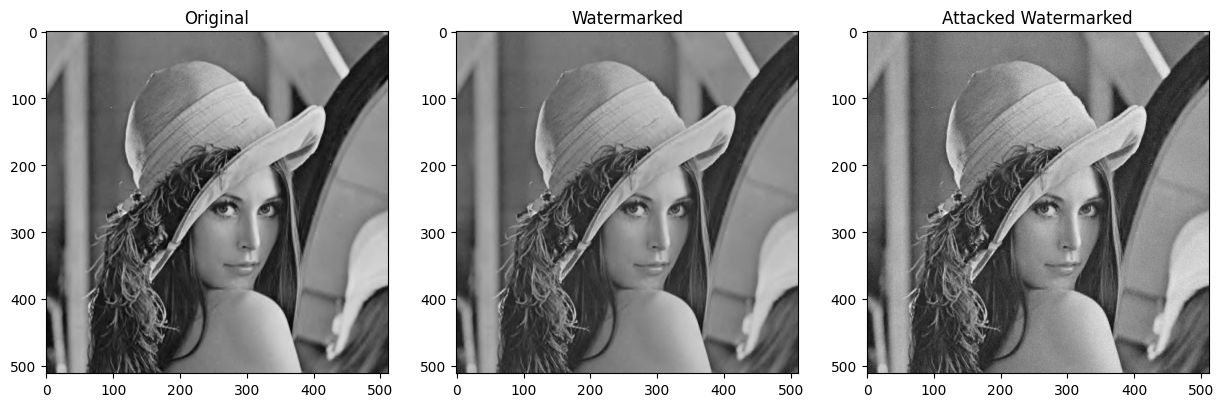

In [37]:
import importlib

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s


def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs

#select your attack 

def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return np.uint8(attacked)


def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(image, 'haar')
    LL0_or, (LH0_or, HL0_or, HH0_or) = coeffs2
    coeffs3 = pywt.dwt2(LL0_or, 'haar')
    LL1_or, (LH1_or, HL1_or, HH1_or) = coeffs3
    coeffs4 = pywt.dwt2(LL1_or, 'haar')
    LL2_or, (LH2_or, HL2_or, HH2_or) = coeffs4
    coeffs5 = pywt.dwt2(LL2_or, 'haar')
    LL3_or, (LH3_or, HL3_or, HH3_or) = coeffs5

    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs6 = pywt.dwt2(watermarked, 'haar')
    LL0_w, (LH0_w, HL0_w, HH0_w) = coeffs6
    coeffs7 = pywt.dwt2(LL0_w, 'haar')
    LL1_w, (LH1_w, HL1_w, HH1_w) = coeffs7
    coeffs8 = pywt.dwt2(LL1_w, 'haar')
    LL2_w, (LH2_w, HL2_w, HH2_w) = coeffs8
    coeffs9 = pywt.dwt2(LL2_w, 'haar')
    LL3_w, (LH3_w, HL3_w, HH3_w) = coeffs9

    # Create the mask for all the different subbands

    mask_LH0 = np.ones(LH0_or.shape)
    mask_HL0 = np.ones(HL0_or.shape)
    mask_HH0 = np.ones(HH0_or.shape)

    mask_LH1 = np.ones(LH1_or.shape)
    mask_HL1 = np.ones(HL1_or.shape)
    mask_HH1 = np.ones(HH1_or.shape)

    mask_LH2 = np.ones(LH2_or.shape)
    mask_HL2 = np.ones(HL2_or.shape)
    mask_HH2 = np.ones(HH2_or.shape)

    mask_LH0 += create_perceptual_mask(LH0_or)
    mask_HL0 += create_perceptual_mask(HL0_or)
    mask_HH0 += create_perceptual_mask(HH0_or)

    mask_LH1 += create_perceptual_mask(LH1_or)
    mask_HL1 += create_perceptual_mask(HL1_or)
    mask_HH1 += create_perceptual_mask(HH1_or)

    mask_LH2 += create_perceptual_mask(LH2_or)
    mask_HL2 += create_perceptual_mask(HL2_or)
    mask_HH2 += create_perceptual_mask(HH2_or)


    # Get the locations in LH2
    sign_LH2 = np.sign(LH2_or)
    abs_LH2 = abs(LH2_or)
    locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
    rows_LH2 = LH2_or.shape[0]
    locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates


    # Get the locations in HL2
    sign_HL2 = np.sign(HL2_or)
    abs_HL2 = abs(HL2_or)
    locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
    rows_HL2 = HL2_or.shape[0]
    locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

    # Get the locations in HH2
    sign_HH2 = np.sign(HH2_or)
    abs_HH2 = abs(HH2_or)
    locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
    rows_HH2 = HH2_or.shape[0]
    locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1_2 = np.zeros(mark_size, dtype=np.float64)
    w_ex2_2 = np.zeros(mark_size, dtype=np.float64)
    w_ex3_2 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH2[1:mark_size+1]):
        if v=='additive':
            x = locations_LH2[idx][0]
            y = locations_LH2[idx][1]
            w_ex1_2[idx] =  (LH2_w[loc] - LH2_or[loc]) / modularAlpha(2, 0, alpha) * mask_LH2[x][y]
        elif v=='multiplicative':
            x = locations_LH2[idx][0]
            y = locations_LH2[idx][1]
            w_ex1_2[idx] =  (LH2_w[loc] - LH2_or[loc]) / (modularAlpha(2, 0, alpha) * mask_LH2[x][y] * LH2_or[loc])

    # Embed the watermark
    for idx, loc in enumerate(locations_HL2[1:mark_size+1]):
        if v=='additive':
            x = locations_HL2[idx][0]
            y = locations_HL2[idx][1]
            w_ex1_2[idx] =  (HL2_w[loc] - HL2_or[loc]) / modularAlpha(2, 2, alpha) * mask_HL2[x][y]
        elif v=='multiplicative':
            x = locations_HL2[idx][0]
            y = locations_HL2[idx][1]
            w_ex1_2[idx] =  (HL2_w[loc] - HL2_or[loc]) / (modularAlpha(2, 2, alpha) * mask_HL2[x][y] * HL2_or[loc])
    
    # Embed the watermark
    for idx, loc in enumerate(locations_HH2[1:mark_size+1]):
        if v=='additive':
            x = locations_HH2[idx][0]
            y = locations_HH2[idx][1]
            w_ex1_2[idx] =  (HH2_w[loc] - HH2_or[loc]) / modularAlpha(2, 1, alpha) * mask_HH2[x][y]
        elif v=='multiplicative':
            x = locations_HH2[idx][0]
            y = locations_HH2[idx][1]
            w_ex1_2[idx] =  (HH2_w[loc] - HH2_or[loc]) / (modularAlpha(2, 1, alpha) * mask_HH2[x][y] * HH2_or[loc])

     # Get the locations in LH1
    sign_LH1 = np.sign(LH1_or)
    abs_LH1 = abs(LH1_or)
    locations_LH1 = np.argsort(-abs_LH1,axis=None) # - sign is used to get descending order
    rows_LH1 = LH1_or.shape[0]
    locations_LH1 = [(val//rows_LH1, val%rows_LH1) for val in locations_LH1] # locations as (x,y) coordinates


    # Get the locations in HL1
    sign_HL1 = np.sign(HL1_or)
    abs_HL1 = abs(HL1_or)
    locations_HL1 = np.argsort(-abs_HL1,axis=None) # - sign is used to get descending order
    rows_HL1 = HL1_or.shape[0]
    locations_HL1 = [(val//rows_HL1, val%rows_HL1) for val in locations_HL1] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH1 = np.sign(HH1_or)
    abs_HH1 = abs(HH1_or)
    locations_HH1 = np.argsort(-abs_HH1,axis=None) # - sign is used to get descending order
    rows_HH1 = HH1_or.shape[0]
    locations_HH1 = [(val//rows_HH1, val%rows_HH1) for val in locations_HH1] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1_1 = np.zeros(mark_size, dtype=np.float64)
    w_ex2_1 = np.zeros(mark_size, dtype=np.float64)
    w_ex3_1 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH1[1:mark_size+1]):
        if v=='additive':
            x = locations_LH1[idx][0]
            y = locations_LH1[idx][1]
            w_ex1_1[idx] =  (LH1_w[loc] - LH1_or[loc]) / modularAlpha(1, 0, alpha) * mask_LH1[x][y]
        elif v=='multiplicative':
            x = locations_LH1[idx][0]
            y = locations_LH1[idx][1]
            w_ex1_1[idx] =  (LH1_w[loc] - LH1_or[loc]) / (modularAlpha(1, 0, alpha) * mask_LH1[x][y] * LH1_or[loc])

    # Embed the watermark
    for idx, loc in enumerate(locations_HL1[1:mark_size+1]):
        if v=='additive':
            x = locations_HL1[idx][0]
            y = locations_HL1[idx][1]
            w_ex1_1[idx] =  (HL1_w[loc] - HL1_or[loc]) / modularAlpha(1, 2, alpha) * mask_HL1[x][y]
        elif v=='multiplicative':
            x = locations_HL1[idx][0]
            y = locations_HL1[idx][1]
            w_ex1_1[idx] =  (HL1_w[loc] - HL1_or[loc]) / (modularAlpha(1, 2, alpha) * mask_HL1[x][y] * HL1_or[loc])
    
    # Embed the watermark
    for idx, loc in enumerate(locations_HH1[1:mark_size+1]):
        if v=='additive':
            x = locations_HH1[idx][0]
            y = locations_HH1[idx][1]
            w_ex1_1[idx] =  (HH1_w[loc] - HH1_or[loc]) / modularAlpha(1, 1, alpha) * mask_HH1[x][y]
        elif v=='multiplicative':
            x = locations_HH1[idx][0]
            y = locations_HH1[idx][1]
            w_ex1_1[idx] =  (HH1_w[loc] - HH1_or[loc]) / (modularAlpha(1, 1, alpha) * mask_HH1[x][y] * HH1_or[loc])
    
     # Get the locations in LH0
    sign_LH0 = np.sign(LH0_or)
    abs_LH0 = abs(LH0_or)
    locations_LH0 = np.argsort(-abs_LH0,axis=None) # - sign is used to get descending order
    rows_LH0 = LH0_or.shape[0]
    locations_LH0 = [(val//rows_LH0, val%rows_LH0) for val in locations_LH0] # locations as (x,y) coordinates


    # Get the locations in HL0
    sign_HL0 = np.sign(HL0_or)
    abs_HL0 = abs(HL0_or)
    locations_HL0 = np.argsort(-abs_HL0,axis=None) # - sign is used to get descending order
    rows_HL0 = HL0_or.shape[0]
    locations_HL0 = [(val//rows_HL0, val%rows_HL0) for val in locations_HL0] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH0 = np.sign(HH0_or)
    abs_HH0 = abs(HH0_or)
    locations_HH0 = np.argsort(-abs_HH0,axis=None) # - sign is used to get descending order
    rows_HH0 = HH0_or.shape[0]
    locations_HH0 = [(val//rows_HH0, val%rows_HH0) for val in locations_HH0] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1_0 = np.zeros(mark_size, dtype=np.float64)
    w_ex2_0 = np.zeros(mark_size, dtype=np.float64)
    w_ex3_0 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH0[1:mark_size+1]):
        if v=='additive':
            x = locations_LH0[idx][0]
            y = locations_LH0[idx][1]
            w_ex1_0[idx] =  (LH0_w[loc] - LH0_or[loc]) / modularAlpha(0, 0, alpha) * mask_LH0[x][y]
        elif v=='multiplicative':
            x = locations_LH0[idx][0]
            y = locations_LH0[idx][1]
            w_ex1_0[idx] =  (LH0_w[loc] - LH0_or[loc]) / (modularAlpha(0, 0, alpha) * mask_LH0[x][y] * LH0_or[loc])

    # Embed the watermark
    for idx, loc in enumerate(locations_HL0[1:mark_size+1]):
        if v=='additive':
            x = locations_HL0[idx][0]
            y = locations_HL0[idx][1]
            w_ex1_0[idx] =  (HL0_w[loc] - HL0_or[loc]) / modularAlpha(0, 2, alpha) * mask_HL0[x][y]
        elif v=='multiplicative':
            x = locations_HL0[idx][0]
            y = locations_HL0[idx][1]
            w_ex1_0[idx] =  (HL0_w[loc] - HL0_or[loc]) / (modularAlpha(0, 2, alpha) * mask_HL0[x][y] * HL0_or[loc])
    
    # Embed the watermark
    for idx, loc in enumerate(locations_HH0[1:mark_size+1]):
        if v=='additive':
            x = locations_HH0[idx][0]
            y = locations_HH0[idx][1]
            w_ex1_0[idx] =  (HH0_w[loc] - HH0_or[loc]) / modularAlpha(0, 1, alpha) * mask_HH0[x][y]
        elif v=='multiplicative':
            x = locations_HH0[idx][0]
            y = locations_HH0[idx][1]
            w_ex1_0[idx] =  (HH0_w[loc] - HH0_or[loc]) / (modularAlpha(0, 1, alpha) * mask_HH0[x][y] * HH0_or[loc])

    return [w_ex1_0, w_ex2_0, w_ex3_0, w_ex1_1, w_ex2_1, w_ex3_1, w_ex1_2, w_ex2_2, w_ex3_2]

#######  your attack  ########

attacked = awgn(watermarkedPicture, 6, 123)




plt.figure(figsize=(15, 9))
plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarkedPicture, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')

#detection
candidate_wm = detection(image, watermarkedPicture, alpha, N, v)
attacked_wm = detection(image, attacked, alpha, N, v)

#wpsnr
wspnr_watermarked = wpsnr(image, watermarkedPicture)
wpsner_attacked = wpsnr(watermarkedPicture, attacked)
print('\n')
print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)
print('WPSNR ATTACKED IMAGE = ', wpsner_attacked)

#similarity
sims_attacked = []
sims_not_attacked = []
for i,j in zip(candidate_wm, attacked_wm):
    sims_attacked.append(similarity(i, j))
    sims_not_attacked.append(similarity(i, mark))


print(mark)
print(candidate_wm[0])
print(candidate_wm[1])
print(candidate_wm[2])
sim_Attacked = max(sims_attacked)
sim_NOTattacked = max(sims_not_attacked)
Tau, _ = compute_thr(sim_NOTattacked, N, mark, 1000)
#watermark retrieved?
print('\n')
if sim_NOTattacked > Tau:
    print('Mark has been found in the non-attacked image. SIM = %f' % sim_NOTattacked)
else:
    print('Mark has been lost in the non-attacked image. SIM = %f' % sim_NOTattacked)
if sim_Attacked > Tau:
    print('Mark has been found in the attacked image. SIM = %f' % sim_Attacked)
else:
    print('Mark has been lost in the attacked image. SIM = %f' % sim_Attacked)
print('--------------------------')
print('\n')

In [39]:
def calculate_parity_bits(data_bits):
    """Calculate the parity bits for a 4-bit data message."""
    p1 = data_bits[0] ^ data_bits[1] ^ data_bits[3]  # Parity for bits 1, 3, 5, 7
    p2 = data_bits[0] ^ data_bits[2] ^ data_bits[3]  # Parity for bits 2, 3, 6, 7
    p3 = data_bits[1] ^ data_bits[2] ^ data_bits[3]  # Parity for bits 4, 5, 6, 7
    return [p1, p2, p3]

def hamming_encode(data_bits):
    """Encode 4 data bits into a 7-bit Hamming (7,4) code."""
    if len(data_bits) != 4:
        raise ValueError("Input must be a list of 4 data bits.")
    
    # Calculate parity bits
    p1, p2, p3 = calculate_parity_bits(data_bits)
    
    # Arrange the codeword: [p1, p2, data1, p3, data2, data3, data4]
    codeword = [p1, p2, data_bits[0], p3, data_bits[1], data_bits[2], data_bits[3]]
    
    return codeword

def split_into_blocks(bit_string, block_size=4):
    """Split the bit string into blocks of size block_size."""
    return [bit_string[i:i + block_size] for i in range(0, len(bit_string), block_size)]

def encode_1024_bit_string(bit_string):
    """Encode a 1024-bit string using Hamming (7,4) encoding in blocks of 4 bits."""
    if len(bit_string) != 1024:
        raise ValueError("Input string must be exactly 1024 bits long.")
    
    # Split the bit string into 4-bit blocks
    blocks = split_into_blocks(bit_string, 4)
    
    # Prepare to store the encoded blocks
    encoded_blocks = []
    
    # Encode each 4-bit block using Hamming (7,4)
    for block in blocks:
        # Convert each 4-bit block (string) into a list of integers
        data_bits = [int(bit) for bit in block]
        
        # Encode the block and add the resulting 7-bit codeword to encoded_blocks
        encoded_blocks.append(hamming_encode(data_bits))
    
    # Flatten the list of encoded blocks into a single list of bits
    encoded_bits = [bit for block in encoded_blocks for bit in block]
    
    # Convert the list of bits into a string
    encoded_string = ''.join(map(str, encoded_bits))
    
    return encoded_string

# Example usage:
bit_string = '110101011010' * 85 + '0' * 4  # Example 1024-bit string (repeated pattern)
encoded_result = encode_1024_bit_string(bit_string)

print(f"Original 1024-bit string: {bit_string[:60]}...")  # Print a small portion for brevity
print(f"Encoded string (7,4 Hamming blocks): {encoded_result[:105]}...")  # Print a small portion for brevity
print(f"Encoded length: {len(encoded_result)} bits")


Original 1024-bit string: 110101011010110101011010110101011010110101011010110101011010...
Encoded string (7,4 Hamming blocks): 101010101001011011010101010101001011011010101010101001011011010101010101001011011010101010101001011011010...
Encoded length: 1792 bits


In [42]:
def hamming_decode(codeword):
    """Decode the 7-bit Hamming code, correct single-bit errors, and extract the original 4 data bits."""
    if len(codeword) != 7:
        raise ValueError("Codeword must be 7 bits long.")
    
    # Extract the parity and data bits
    p1, p2, d1, p3, d2, d3, d4 = codeword
    
    # Recalculate the parity bits based on the received data
    c1 = p1 ^ d1 ^ d2 ^ d4  # Check parity bit 1
    c2 = p2 ^ d1 ^ d3 ^ d4  # Check parity bit 2
    c3 = p3 ^ d2 ^ d3 ^ d4  # Check parity bit 3
    
    # Combine the parity check results into a single error syndrome
    error_position = (c3 << 2) | (c2 << 1) | c1  # Binary value gives error position
    
    # If error_position is non-zero, correct the error
    if error_position != 0:
        print(f"Error detected at position {error_position}. Correcting...")
        codeword[error_position - 1] ^= 1  # Flip the bit at the error position
    
    # Extract the original data bits from the corrected codeword
    data_bits = [codeword[2], codeword[4], codeword[5], codeword[6]]
    
    return data_bits

def split_into_blocks(bit_string, block_size):
    """Split the bit string into blocks of size block_size."""
    return [bit_string[i:i + block_size] for i in range(0, len(bit_string), block_size)]

def decode_1792_bit_string(encoded_string):
    """Decode a 1792-bit Hamming (7,4) encoded string back into a 1024-bit string."""
    if len(encoded_string) != 1792:
        raise ValueError("Input string must be exactly 1792 bits long.")
    
    # Split the encoded string into 7-bit blocks
    encoded_blocks = split_into_blocks(encoded_string, 7)
    
    # Prepare to store the decoded data bits
    decoded_data_bits = []
    
    # Decode each 7-bit block and extract the original 4 data bits
    for block in encoded_blocks:
        # Convert the 7-bit block (string) into a list of integers
        codeword = [int(bit) for bit in block]
        
        # Decode the block to get the original 4 data bits
        decoded_bits = hamming_decode(codeword)
        
        # Append the decoded 4 data bits to the result
        decoded_data_bits.extend(decoded_bits)
    
    # Convert the list of decoded data bits into a string
    decoded_string = ''.join(map(str, decoded_data_bits))
    
    return decoded_string

# Example usage:
encoded_string = encoded_result
print(type(encoded_string))
decoded_result = decode_1792_bit_string(encoded_string)

print(f"Decoded 1024-bit string: {decoded_result[:60]}...")  # Print a small portion for brevity
print(f"Decoded length: {len(decoded_result)} bits")


<class 'str'>
Decoded 1024-bit string: 110101011010110101011010110101011010110101011010110101011010...
Decoded length: 1024 bits


In [5]:
!pip install --upgrade pyldpc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 27.9 MB/s eta 0:00:0031m29.1 MB/s eta 0:00:01
  Created wheel for pyldpc: filename=pyldpc-0.7.9-py3-none-any.whl size=14303 sha256=b07c32cf0acf928862bbbf0ebecb705d776616018b153fc779d151d81c73b6e7
  Stored in directory: /home/ale/.cache/pip/wheels/00/f1/5f/d89afe3e8ba95547a385c49f048742fb3fd0aab91eb274c490
Successfully built pyldpc


In [62]:
import numpy as np
from pyldpc import make_ldpc, encode, decode, get_message
n = 2048
d_v = 4
d_c = 8
snr = 20
H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
markExtended = np.append(mark, [0, 0, 0])
y = encode(G, markExtended, snr)


for _ in range(4096):
    y[np.random.randint(0, 2048)] = np.random.randint(0, 1)


d = decode(H, y, snr, maxiter=100)
x = get_message(G, d)
markExtracted = np.delete(x, np.s_[-3:])
print(abs(mark - markExtracted).sum() == 0)
print(similarity(mark, markExtracted))

# n = 2040, k = 1023
# n = 2048, k = 1027

False
0.7205352069510265


In [4]:
!pip install tdqm

  Preparing metadata (setup.py) ... done
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.66.5-py3-none-any.whl (78 kB)
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1320 sha256=41fba46a72a7a39a8ba48aeaf7fbd0add77bfba2c66560a625ac95ff84d0bd1d
  Stored in directory: /home/ale/.cache/pip/wheels/86/cd/38/f96ed05dd8049e95d8fbeaa0587664eb001a1848979636b771
Successfully built tdqm


65536
65536


WPSNR non-ATTACKED IMAGE =  34.56218718324586
WPSNR ATTACKED IMAGE =  29.606846496957452
Threshold:  0.7048809930600858


Mark has been lost in the non-attacked image. SIM = 0.026959
Mark has been lost in the attacked image. SIM = 0.169939
--------------------------




Applying DWT_GAUSS: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it]       


Best attack: JPEG Compression, PSNR: 58.86501517754957, WPSNR: 73.92489113615429, Params: QF: 100
{'mean_psnr': 20.809526821409616, 'mean_wpsnr': 34.28956742689658, 'best_wpsnr': 73.92489113615429, 'worst_wpsnr': 11.536369331812788, 'total_lost': 0}


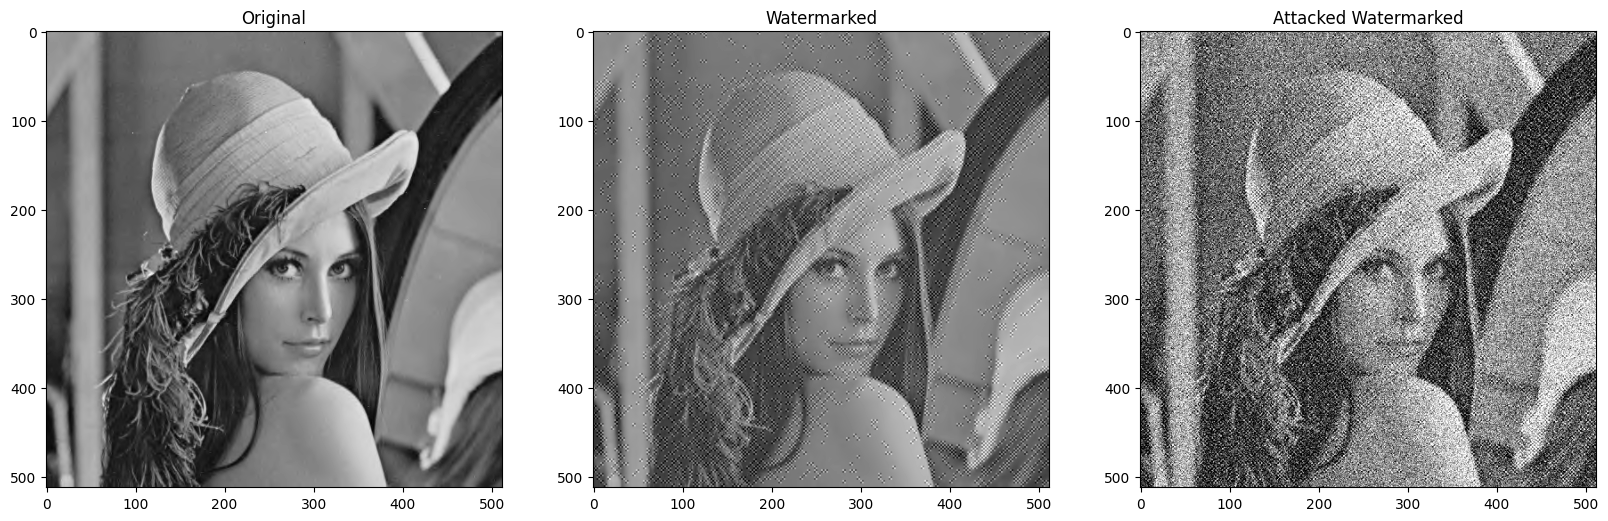

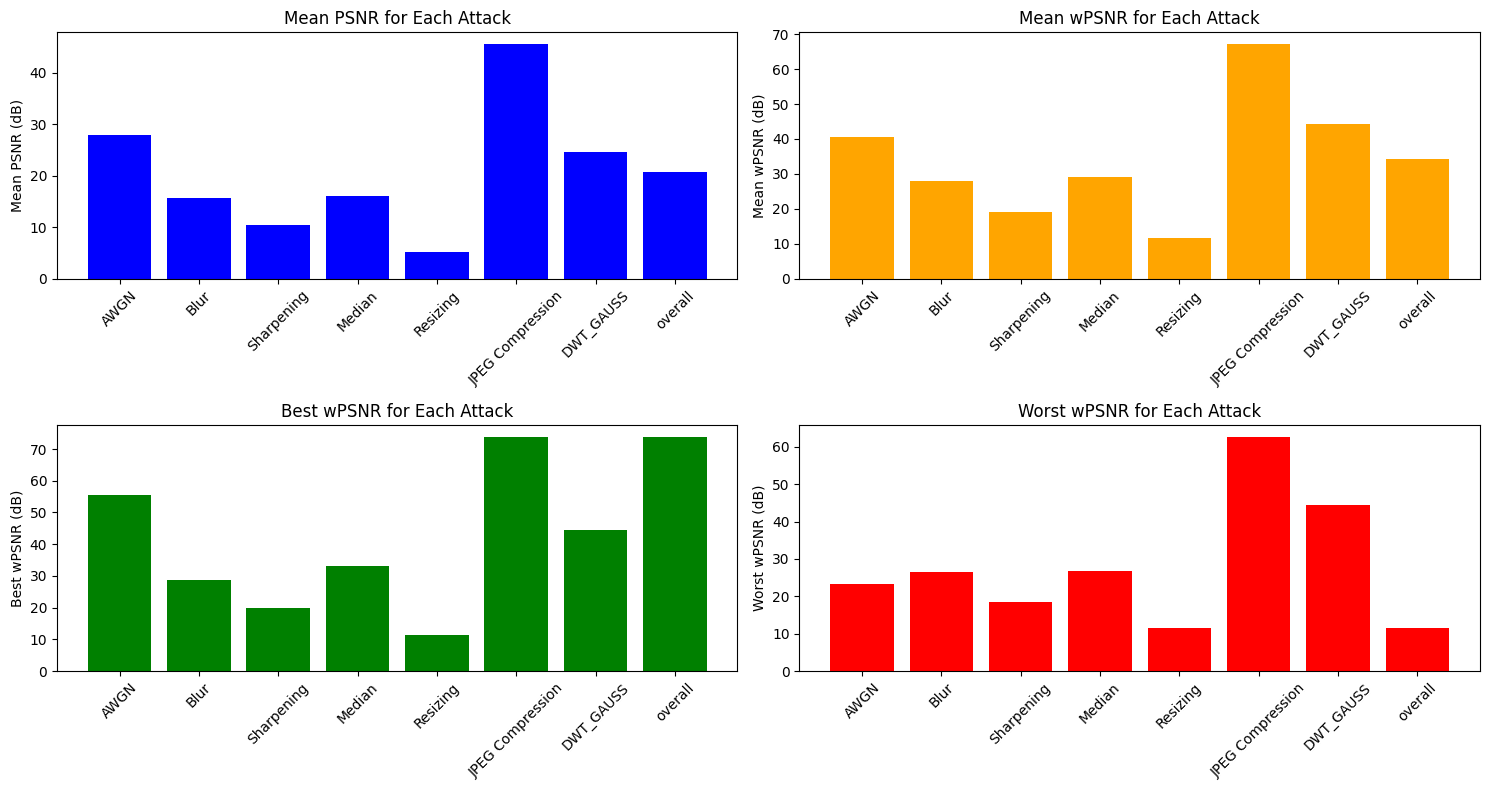

In [4]:
#5
import pywt
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s


def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs
#select your attack 

def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return np.uint8(attacked)

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

import numpy as np
import cv2
from scipy.fftpack import dct, idct
import pywt

# Perceptual mask based on texture and intensity (edge detection and contrast sensitivity)
def perceptual_mask(image):
    # Use Sobel filter to detect edges (high-frequency areas)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    edge_mask = np.hypot(sobelx, sobely)
    
    # Normalize the edge mask
    edge_mask = edge_mask / edge_mask.max()

    # Combine with intensity sensitivity (brighter areas are less sensitive to changes)
    intensity_mask = image.astype(np.float64) / 255.0
    perceptual_mask = 0.5 * edge_mask + 0.5 * (1 - intensity_mask)  # Weighting between edges and intensity

    return perceptual_mask

# Modify the embeddingDCT function to use a perceptual mask and skip significant coefficients
def embeddingDCT(image, mark_size, alpha, mark, perceptual_mask, v='multiplicative'):
    # Get the DCT transform of the image
    ori_dct = dct(dct(image, axis=0, norm='ortho'), axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    sign = np.sign(ori_dct)
    ori_dct = abs(ori_dct)
    locations = np.argsort(-ori_dct, axis=None)  # Sort in descending order of DCT magnitude
    rows = image.shape[0]
    locations = [(val // rows, val % rows) for val in locations]  # Convert to (x, y) coordinates

    # Embed the watermark selectively, using the perceptual mask
    watermarked_dct = ori_dct.copy()
    mark_idx = 0
    
    # Skip the first 10 most significant DCT coefficients
    for idx, loc in enumerate(locations[-mark_size:]):  # Skip top 10 coefficients
        if mark_idx >= len(mark):  # Stop if we've used all watermark bits
            break

        x, y = loc
        perceptual_weight = perceptual_mask[x, y]  # Use perceptual weight for current location
        mark_val = mark[mark_idx]
        mark_idx += 1

        # Apply alpha scaled by perceptual weight
        if v == 'additive':
            watermarked_dct[x, y] += (alpha * perceptual_weight * mark_val)
        elif v == 'multiplicative':
            watermarked_dct[x, y] *= 1 + (alpha * perceptual_weight * mark_val)

    # Restore sign and go back to spatial domain
    watermarked_dct *= sign
    watermarked = np.uint8(idct(idct(watermarked_dct, axis=1, norm='ortho'), axis=0, norm='ortho'))

    return watermarked

# Updated embedding function using the perceptual mask
def embedding(image, mark_size, alpha, v='multiplicative'):
    mark_size = mark_size
    alpha = alpha

    # Generate a random watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    # Get the perceptual mask
    mask = perceptual_mask(image)

    # Perform DWT to get subbands
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2

    # Perform DWT to get subbands
    coeffs3 = pywt.dwt2(LL, 'haar')
    LL1, (LH1, HL1, HH1) = coeffs3

    # Embed watermark in HH subband using the perceptual mask
    watermarkedHH1 = embeddingDCT(HH1, mark_size, alpha, mark, mask)

    # Reconstruct the watermarked image using inverse DWT
    watermarkedLL1 = pywt.idwt2((LL1, (LH1, HL1, watermarkedHH1)), 'haar')

    # Reconstruct the watermarked image using inverse DWT
    watermarked = pywt.idwt2((watermarkedLL1, (LH, HL, HH)), 'haar')

    return mark, watermarked



def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    # Perform wavelet transform on the original and watermarked images
    coeffs2_or = pywt.dwt2(image, 'haar')
    LL_or, (LH_or, HL_or, HH_or) = coeffs2_or
    coeffs2_w = pywt.dwt2(watermarked, 'haar')
    LL_w, (LH_w, HL_w, HH_w) = coeffs2_w

    # Compute DCT of the HH subband (where the watermark was embedded)
    ori_dct = dct(dct(HH_or, axis=0, norm='ortho'), axis=1, norm='ortho')
    wat_dct = dct(dct(HH_w, axis=0, norm='ortho'), axis=1, norm='ortho')

    # Get the absolute values of DCT coefficients
    ori_dct_abs = abs(ori_dct)
    wat_dct_abs = abs(wat_dct)

    # Sort DCT coefficients by magnitude to get perceptually significant components
    locations = np.argsort(-ori_dct_abs, axis=None)  # Descending order of significance
    rows = HH_or.shape[0]
    locations = [(val // rows, val % rows) for val in locations]  # Convert to (x, y) coordinates

    # Compute the perceptual mask based on the original image
    mask = perceptual_mask(image)

    # Initialize an array to store the extracted watermark
    w_ex = np.zeros(mark_size, dtype=np.float64)

    # Skip the first few DCT coefficients and extract the watermark using the perceptual mask
    mark_idx = 0
    print(len(locations))
    for idx, loc in enumerate(locations[-mark_size:]):  # Skip the first 10 coefficients as in embedding
        if mark_idx >= mark_size:  # Stop if we've extracted all watermark bits
            break

        x, y = loc
        perceptual_weight = mask[x, y]  # Use perceptual weight for current location

        if v == 'additive':
            w_ex[mark_idx] = (wat_dct_abs[x, y] - ori_dct_abs[x, y]) / (alpha * perceptual_weight)
        elif v == 'multiplicative':
            w_ex[mark_idx] = (wat_dct_abs[x, y] / ori_dct_abs[x, y] - 1) / (alpha * perceptual_weight)
        
        mark_idx += 1

    return w_ex


plt.figure(figsize=(20, 20))

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alpha = 1
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)

mark, watermarked1 = embedding(image, N, alpha, v)

#your attack


attacked = awgn(watermarked1, 50, 123)


plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarked1, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')
#detection

w_ex = detection(image, watermarked1, alpha, N, v)
w_ex_att = detection(image, attacked, alpha, N, v)

#wpsnr
wspnr_watermarked = wpsnr(image, watermarked1)
wpsner_attacked = wpsnr(watermarked1, attacked)
print('\n')
print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)
print('WPSNR ATTACKED IMAGE = ', wpsner_attacked)
#similarity
sim_Attacked = similarity(w_ex,w_ex_att)
sim_NOTattacked = similarity(mark,w_ex)
Tau, _ = compute_thr(sim_NOTattacked, N, mark, 1000)
#watermark retrieved?
print('\n')
if sim_NOTattacked > Tau:
        print('Mark has been found in the non-attacked image. SIM = %f' % sim_NOTattacked)
else:
        print('Mark has been lost in the non-attacked image. SIM = %f' % sim_NOTattacked)
if sim_Attacked > Tau:
        print('Mark has been found in the attacked image. SIM = %f' % sim_Attacked)
else:
        print('Mark has been lost in the attacked image. SIM = %f' % sim_Attacked)
print('--------------------------')
print('\n')

import sys
sys.path.append(os.path.join(os.getcwd(), 'common'))
import importlib
import attacks as attacks

# Reload the entire module, not the function
importlib.reload(attacks)

(history,_) = attacks.multiple_attacks(watermarked1)   #INSERT YOUR EMBEDDED IMAGE HERE
#print(history)
stats = attacks.stats(history)               #compute the statistics
print(stats['overall'])
attacks.plot_stats(stats)                    #visualize the statics

In [71]:
def create_perceptual_mask(subband):

    mask = np.ones(subband.shape)
    mask += compute_brightness_sensitivity(subband) * compute_edge_sensitivity(subband) * compute_texture_sensitivity(subband)
    
    return mask

def compute_brightness_sensitivity(subband):

    # Normalize brightness between 0 and 1
    min_brightness = np.min(subband)
    max_brightness = np.max(subband)
    brightness_sensitivity = (subband - min_brightness) / (max_brightness - min_brightness + 1e-6)
    
    # Invert to give higher sensitivity in dark areas (lower brightness = higher mask value)
    return 1 - brightness_sensitivity

def compute_edge_sensitivity(subband):

    # Compute image gradient (strong edges correspond to higher gradients)
    sobel_x = cv2.Sobel(subband, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(subband, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Normalize gradient magnitude between 0 and 1
    gradient_sensitivity = (gradient_magnitude - np.min(gradient_magnitude)) / (np.max(gradient_magnitude) - np.min(gradient_magnitude) + 1e-6)
    
    return gradient_sensitivity

def compute_texture_sensitivity(subband):
    
    # Compute local variance as a measure of texture
    mean = cv2.blur(subband, (3, 3))
    local_variance = cv2.blur((subband - mean) ** 2, (3, 3))
    
    # Normalize local variance between 0 and 1
    texture_sensitivity = (local_variance - np.min(local_variance)) / (np.max(local_variance) - np.min(local_variance) + 1e-6)
    
    return texture_sensitivity

def modular_alpha(layer, theta, alpha):
    arrayLayer = [1.0, 0.32, 0.16, 0.1]
    arrayTheta = [1, sqrt(2), 1]

    return alpha * arrayLayer[layer] * arrayTheta[theta]

def get_locations(subband):
    sign = np.sign(subband)
    abs_subband = abs(subband)
    locations = np.argsort(-abs_subband, axis=None) # - sign is used to get descending order
    rows = subband.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    return abs_subband, sign, locations

def embed_watermark(subband, mark, layer, theta, alpha=0.5, v='multiplicative'):

    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband) 

    watermarked = abs_subband.copy()
    for idx, (loc, mark_val) in enumerate(zip(locations[1:], mark)):
        x = locations[idx][0]
        y = locations[idx][1]
        if v == 'additive':
            watermarked[loc] += (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
        elif v == 'multiplicative':
            watermarked[loc] *= 1 + (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])

            # wm_new[loc] = wm[loc] * (1 + (modular_alpha * mark * mask))
            # wm_new = wm[loc] + wm[ * wm(alpha * mask * mark)
            # (wm_new - wm)/wm = wm(alpha * mask * mark)
            # (wm_new - wm) / (wm^2 * alpha * mask) = mark 
    
    return sign * watermarked

def recursive_embedding(coeffs, mark, alpha, layer, max_layer, v='multiplicative'):
    LL, (LH, HL, HH) = coeffs

    # Base case: if we reach layer 3, embed the watermark and return
    if layer == max_layer:
        watermarked_LH = embed_watermark(LH, mark, layer, 0, alpha, v)
        watermarked_HL = embed_watermark(HL, mark, layer, 2, alpha, v)
        watermarked_HH = embed_watermark(HH, mark, layer, 1, alpha, v)

        watermarked_LL = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
        return watermarked_LL

    # Recursive case: perform another DWT and recurse
    coeffs_next = pywt.dwt2(LL, 'haar')
    watermarked_LL = recursive_embedding(coeffs_next, mark, alpha, layer + 1, max_layer, v)

    # Embed the watermark at this layer
    watermarked_LH = embed_watermark(LH, mark, layer, 0, alpha, v)
    watermarked_HL = embed_watermark(HL, mark, layer, 2, alpha, v)
    watermarked_HH = embed_watermark(HH, mark, layer, 1, alpha, v)

    # Return the inverse DWT of the watermarked image
    watermarked = pywt.idwt2((watermarked_LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
    return watermarked


def embedding(image, mark, alpha, max_layer=2, v='multiplicative'):
    # Initial wavelet decomposition
    coeffs = pywt.dwt2(image, 'haar')
    # Start recursive embedding from layer 0
    watermarked_image = recursive_embedding(coeffs, mark, alpha, layer=0, max_layer=max_layer, v=v)
    
    return watermarked_image


def extract_watermark(subband, watermarked_subband, layer, theta, alpha=0.5, v='multiplicative'):
    # Create perceptual mask for the subband
    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband)
    abs_watermarked, _, _ = get_locations(watermarked_subband)
    mark_size = 1024

    extracted_mark = np.zeros(mark_size, dtype=np.float64)

    # Loop through each location (except the first one)
    for idx, loc in enumerate(locations[1:mark_size+1]):
        x = locations[idx][0]
        y = locations[idx][1]
        
        if v == 'additive':
            # Reverse the additive watermarking process to extract the mark
            extracted_mark[idx] = (watermarked_subband[loc] - subband[loc]) / (modular_alpha(layer, theta, alpha) * mask[x][y])
        elif v == 'multiplicative':
            # Reverse the multiplicative watermarking process to extract the mark
            # extracted_mark[idx] = ((watermarked_subband[loc] / subband[loc]) - 1) / (modular_alpha(layer, theta, alpha) * mask[x][y])
            extracted_mark[idx] = (watermarked_subband[loc] - subband[loc]) / modular_alpha(layer, theta, alpha) * mask[x][y] * subband[loc]


        
    return  np.clip(extracted_mark, 0, 1).astype(np.uint8)

def detect_wm(image, watermarked, alpha, max_layer=2, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    LL0_or, (LH0_or, HL0_or, HH0_or) = pywt.dwt2(image, 'haar')
    LL1_or, (LH1_or, HL1_or, HH1_or) = pywt.dwt2(LL0_or, 'haar')
    LL2_or, (LH2_or, HL2_or, HH2_or) = pywt.dwt2(LL1_or, 'haar')
     

    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    LL0_w, (LH0_w, HL0_w, HH0_w) = pywt.dwt2(watermarked, 'haar')
    LL1_w, (LH1_w, HL1_w, HH1_w) = pywt.dwt2(LL0_w, 'haar')
    LL2_w, (LH2_w, HL2_w, HH2_w) = pywt.dwt2(LL1_w, 'haar')
    
    extracted_wms = []

    if max_layer == 2:
        extracted_wms.append(extract_watermark(LH2_or, LH2_w, 2, 0, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HL2_or, HL2_w, 2, 2, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HH2_or, HH2_w, 2, 1, alpha=alpha, v=v))
    if max_layer >= 1:
        extracted_wms.append(extract_watermark(LH1_or, LH1_w, 1, 0, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HL1_or, HL1_w, 1, 2, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HH1_or, HH1_w, 1, 1, alpha=alpha, v=v))

    extracted_wms.append(extract_watermark(LH0_or, LH0_w, 0, 0, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HL0_or, HL0_w, 0, 2, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HH0_or, HH0_w, 0, 1, alpha=alpha, v=v))

    return extracted_wms

def detection(original, watermarked, attacked, alpha, max_layer):
    w_ex = detect_wm(original, watermarked, alpha, max_layer=max_layer)
    w_ex_attacked = detect_wm(original, attacked, alpha, max_layer=max_layer)
    thr = 0.7045
    sim = []


    ex_mark = np.zeros(1024, dtype=np.uint8)
    for j in range(1024):
        s = 0
        for i in range(len(w_ex)):
            s += w_ex[i][j]
        if s >= 5:
            ex_mark[j] = 1
        else:
            ex_mark[j] = 0
        
    for w in w_ex_attacked:
        x = similarity(w, ex_mark)
        sim.append(x)
    
    sim = max(sim)

    print(sim)

    if sim >= thr:
        return 1
    return 0



0.8023325894349013


WPSNR non-ATTACKED IMAGE =  46.443659928443644
WPSNR ATTACKED IMAGE =  33.88416870798264


Mark has been found in the attacked image.
--------------------------




Applying DWT_MEIDAN: 100%|██████████| 8/8 [00:16<00:00,  2.10s/it]      


Best attack: JPEG Compression, PSNR: 51.736918560548915, WPSNR: 71.16101925485705, Params: QF: 98
{'mean_psnr': 19.04003816887641, 'mean_wpsnr': 34.22539080527953, 'best_wpsnr': 71.16101925485705, 'worst_wpsnr': 17.90997888937947, 'total_lost': 0}


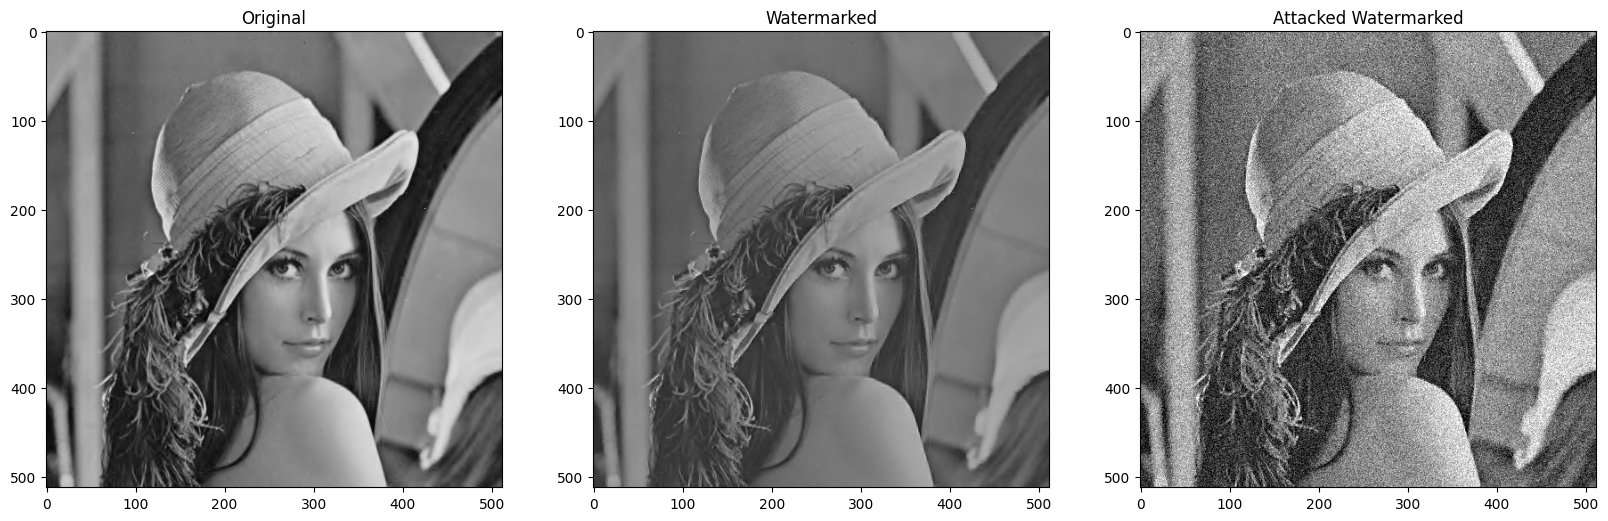

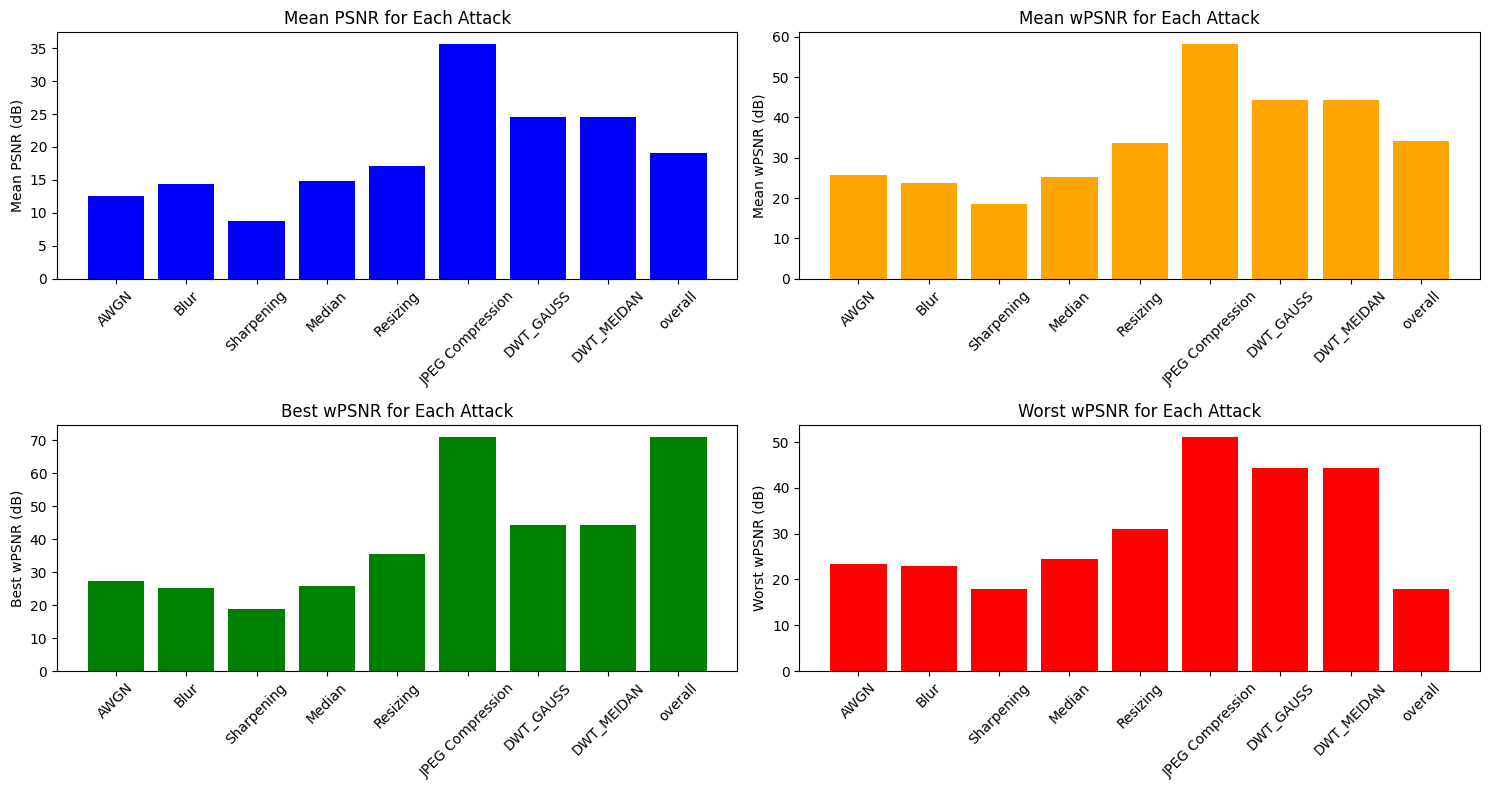

In [75]:
plt.figure(figsize=(20, 20))

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alpha = 1
np.random.seed(seed=123)
mark = np.load('./ammhackati.npy')

image = cv2.imread(img_path, 0)

watermarked = embedding(image, mark = mark, alpha = alpha)

#your attack


attacked = awgn(watermarked, 30, 123)


plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarked, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')
#detection

result = detection(image, watermarked, attacked, alpha, 2)

#wpsnr
wspnr_watermarked = wpsnr(image, watermarked)
wpsner_attacked = wpsnr(watermarked, attacked)
print('\n')
print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)
print('WPSNR ATTACKED IMAGE = ', wpsner_attacked)

#watermark retrieved?
print('\n')

if result:
        print('Mark has been found in the attacked image.')
else:
        print('Mark has been lost in the attacked image.')
print('--------------------------')
print('\n')

import sys
sys.path.append(os.path.join(os.getcwd(), 'common'))
import importlib
import attacks as attacks

# Reload the entire module, not the function
importlib.reload(attacks)

(history,_) = attacks.multiple_attacks(watermarked1)   #INSERT YOUR EMBEDDED IMAGE HERE
#print(history)
stats = attacks.stats(history)               #compute the statistics
print(stats['overall'])
attacks.plot_stats(stats)                    #visualize the statics

# ROC

To find a better threshold estimation, **do not use just one single image**. Adapt the code of the ROC using the Spread Spectrum to compute the scores on different images (i.e. Lena, Baboon, etc.)

## Get new images

Download new images for your experiments from this [link](https://drive.google.com/file/d/1-n9bmQFDBShRN4Tr_WpmCf1jFHOS5MTO/view?usp=drive_link)

In [12]:
##YOUR CODE